In [1]:
'''
Author: YJY 522066928@qq.com
Date: 2024-08-19 10:59:20
LastEditors: YJY 522066928@qq.com
LastEditTime: 2024-08-21 12:32:08
FilePath: \ViT2STInterp\ViT.ipynb
Description: 这是默认设置,请设置`customMade`, 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import glob
import netCDF4 as nc
from torchvision import transforms

scale_factor = 1.3 #数据值域缩放比

def load_data_from_directory(directory, scale_factor=1.0):
    file_paths = glob.glob(f'{directory}/*.nc')
    all_data = []
    all_masks = []
    
    for file_path in file_paths:
        dataset = nc.Dataset(file_path, 'r')
        file_name = os.path.basename(file_path)
        prefix = file_name.split('.')[0]
        data_var = dataset.variables[prefix][:]  # Adjust if needed
        data_var = np.expand_dims(data_var, axis=1)
        mask_var = dataset.variables['mask'][:]
        mask_var = np.expand_dims(mask_var, axis=0)
        missing_value = dataset.variables[prefix]._FillValue

        # Handle missing values
        mask = (mask_var == 1).astype(np.float32)
        data_var[data_var == missing_value] = 0
        data_var = np.nan_to_num(data_var, nan=0.0)

        # Apply scaling factor to the data
        data_var *= scale_factor
        all_data.append(data_var)
        all_masks.append(mask)

        dataset.close()

    # Combine all bands with a new channel dimension

    all_data = np.concatenate(all_data, axis=1)  # Merge all bands into channel dimension
    all_masks = np.concatenate(all_masks, axis=0)
    # Reshape data to fit [batch, time, channels, height, width]
    # all_data = np.expand_dims(all_data, axis=0) # [samples, time, channels, height, width]
    # all_masks = np.expand_dims(all_masks, axis=0) # [samples, channels, height, width]

    return all_data, all_masks

class OceanDataset(Dataset):
    len_frame=4
    def __init__(self, data, mask, transform=None, mask_transform=None, use_random_mask=False, mask_ratio=0.0):
        self.data = data # [time, channels, height, width]
        self.mask = mask # [channels, height, width]
        self.use_random_mask = use_random_mask
        self.mask_ratio = mask_ratio

    def __len__(self,len_frame=len_frame):
        return int(self.data.shape[0]/len_frame)  # Number of sample

    def __getitem__(self, idx,len_frame=len_frame): #? The size and range of idx depend on the __len__
        data_sample = self.data[idx*len_frame:(idx+1)*len_frame, :, :]  # Take the first 4 time frames [channels, time, height, width]
        mask_sample = self.mask[0, :, :]  # Corresponding mask frames [batch, channels, height, width]

        # Convert to torch tensor
        data_sample = torch.tensor(data_sample, dtype=torch.float32)
        mask_sample = torch.tensor(mask_sample, dtype=torch.float32)

        # Generate mask based on data_sample
        data_based_mask = (data_sample == 0).float()
        if self.use_random_mask:
            random_mask = torch.rand_like(mask_sample) < self.mask_ratio
            mask_sample = torch.max(mask_sample, random_mask.float())
        mask_sample = torch.max(mask_sample, data_based_mask)
        meta_data = (data_sample != 0).float()
        return data_sample, mask_sample, meta_data

# Load the meta_data
data_var, mask = load_data_from_directory('G:/YuJinYuan-Experiment/MODIS', scale_factor)

# Create dataset and Dataloader
dataset = OceanDataset(data_var, mask, use_random_mask=True, mask_ratio=0.1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) #? batch_size=1:it does automatically add an extra dimension 

# Example: Get one sample and print the shape (batch_size=1)
for data_sample, mask_sample, meta_data in dataloader:
    print(data_sample.shape,mask_sample.shape,meta_data.shape)  # Should output torch.Size([1, 4, 10, 49, 46])
    # break

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\1\AppData\Local\Temp\ipykernel_10216\3571748511.py:1: SyntaxWarning: invalid escape sequence '\V'
  '''


torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNTransformerForInterpolation(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, patch_size=8, stride=4, cnn_channels=[64, 128]):
        super().__init__()
        self.patch_size = patch_size
        self.stride = stride
        self.num_heads = heads
        
        # CNN layers
        self.cnn_layers = nn.ModuleList([
            nn.Conv3d(10, cnn_channels[0], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(cnn_channels[0], cnn_channels[1], kernel_size=3, padding=1),
            nn.ReLU()
        ])
        
        # Transformer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True),
            num_layers=depth
        )
        
        self.to_patch_embedding = nn.Linear(patch_size * patch_size * cnn_channels[-1], dim)
        self.to_pixel_values = nn.Linear(dim, patch_size * patch_size * 10)
        
        # Final CNN layer to refine output
        self.final_cnn = nn.Conv3d(10, 10, kernel_size=3, padding=1)
    
    def create_patches(self, img):
        B, T, C, H, W = img.shape
        patches = img.unfold(3, self.patch_size, self.stride).unfold(4, self.patch_size, self.stride)
        patches = patches.contiguous().view(B, T, C, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 3, 1, 2, 4, 5).reshape(-1, T, C * self.patch_size * self.patch_size)
        return patches
    
    def reconstruct_image(self, patches, H, W):
        B, T, C, num_patches, patch_h, patch_w = patches.shape
        img = torch.zeros(B, T, C, H, W).to(patches.device)
        count = torch.zeros_like(img)
        
        idx = 0
        for i in range(0, H - patch_h + 1, self.stride):
            for j in range(0, W - patch_w + 1, self.stride):
                img[:, :, :, i:i+patch_h, j:j+patch_w] += patches[:, :, :, idx]
                count[:, :, :, i:i+patch_h, j:j+patch_w] += 1
                idx += 1
        
        img /= count
        return img
    
    def forward(self, img):
        B, T, C, H, W = img.shape
        
        # Apply CNN layers
        x = img.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]
        for cnn_layer in self.cnn_layers:
            x = cnn_layer(x)
        
        # Create patches
        x = x.permute(0, 2, 1, 3, 4)  # [B, T, C, H, W]
        patches = self.create_patches(x)
        
        # Apply Transformer
        patches = self.to_patch_embedding(patches)
        patches = self.transformer(patches)
        
        # Recover pixel values
        recovered_patches = self.to_pixel_values(patches)
        recovered_patches = recovered_patches.view(B, -1, T, C, self.patch_size, self.patch_size)
        recovered_patches = recovered_patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        
        # Reconstruct image
        output = self.reconstruct_image(recovered_patches, H, W)
        
        # Final refinement
        output = output.permute(0, 2, 1, 3, 4)  # [B, C, T, H, W]
        output = self.final_cnn(output)
        output = output.permute(0, 2, 1, 3, 4)  # [B, T, C, H, W]
        
        return output

# 示例
model = CNNTransformerForInterpolation(
    dim=256,
    depth=12,
    heads=16,
    mlp_dim=1024,
    patch_size=8,
    stride=4,
    cnn_channels=[64, 128]
)

# 生成一个假设的4帧10通道49*46影像数据
input_image = torch.randn(1, 4, 10, 49, 46)  # [batch, frames, channels, height, width]

# 进行插补
output_image = model(input_image)

print(output_image.shape)  # 应该是 [1, 4, 10, 49, 46]

torch.Size([1, 4, 10, 49, 46])


In [5]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
num_training_cycles = 2  # Number of times to retrain with new random masks
initial_mask_ratio = 0.2  # Starting mask ratio
mask_ratio_increment = 0.1  # Increment of mask ratio per cycle
weight_factor = 1.0  # Adjust this factor to match the scaling applied to the data
for cycle in range(num_training_cycles):
    current_mask_ratio = initial_mask_ratio + cycle * mask_ratio_increment
    print(f'Training Cycle {cycle+1}/{num_training_cycles}, Mask Ratio: {current_mask_ratio:.2f}')
    
    # 生成数据集和数据加载器
    train_dataset=dataset
    train_loader=dataloader
    # train_dataset = OceanDataset(train_data, train_mask,  use_random_mask=True, mask_ratio=current_mask_ratio)
    # val_dataset = OceanDataset(val_data, val_mask, use_random_mask=False)
    # train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        batch_count = 0
        for data, mask, meta_data in train_loader:
            data = data.to(device)
            mask = mask.to(device)
            meta_data = meta_data.to(device)

            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(data)
            output_image = outputs
            # 只在 meta_data 区域计算损失
            loss_per_pixel = criterion(outputs, data)
            print(loss_per_pixel,outputs.shape,data.shape)
            loss = (loss_per_pixel * meta_data).sum() / meta_data.sum()
            
            # 乘以权重因子
            loss *= weight_factor
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
        
        # 计算平均损失
        avg_loss = total_loss / batch_count
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# 保存模型权重
# torch.save(model.state_dict(), 'ViTForInterpolation.pth')

Training Cycle 1/2, Mask Ratio: 0.20
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
Epoch [1/1], Average Loss: nan
Training Cycle 2/2, Mask Ratio: 0.30
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9, 49, 46]) torch.Size([1, 4, 9, 49, 46])
tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>) torch.Size([1, 4, 9

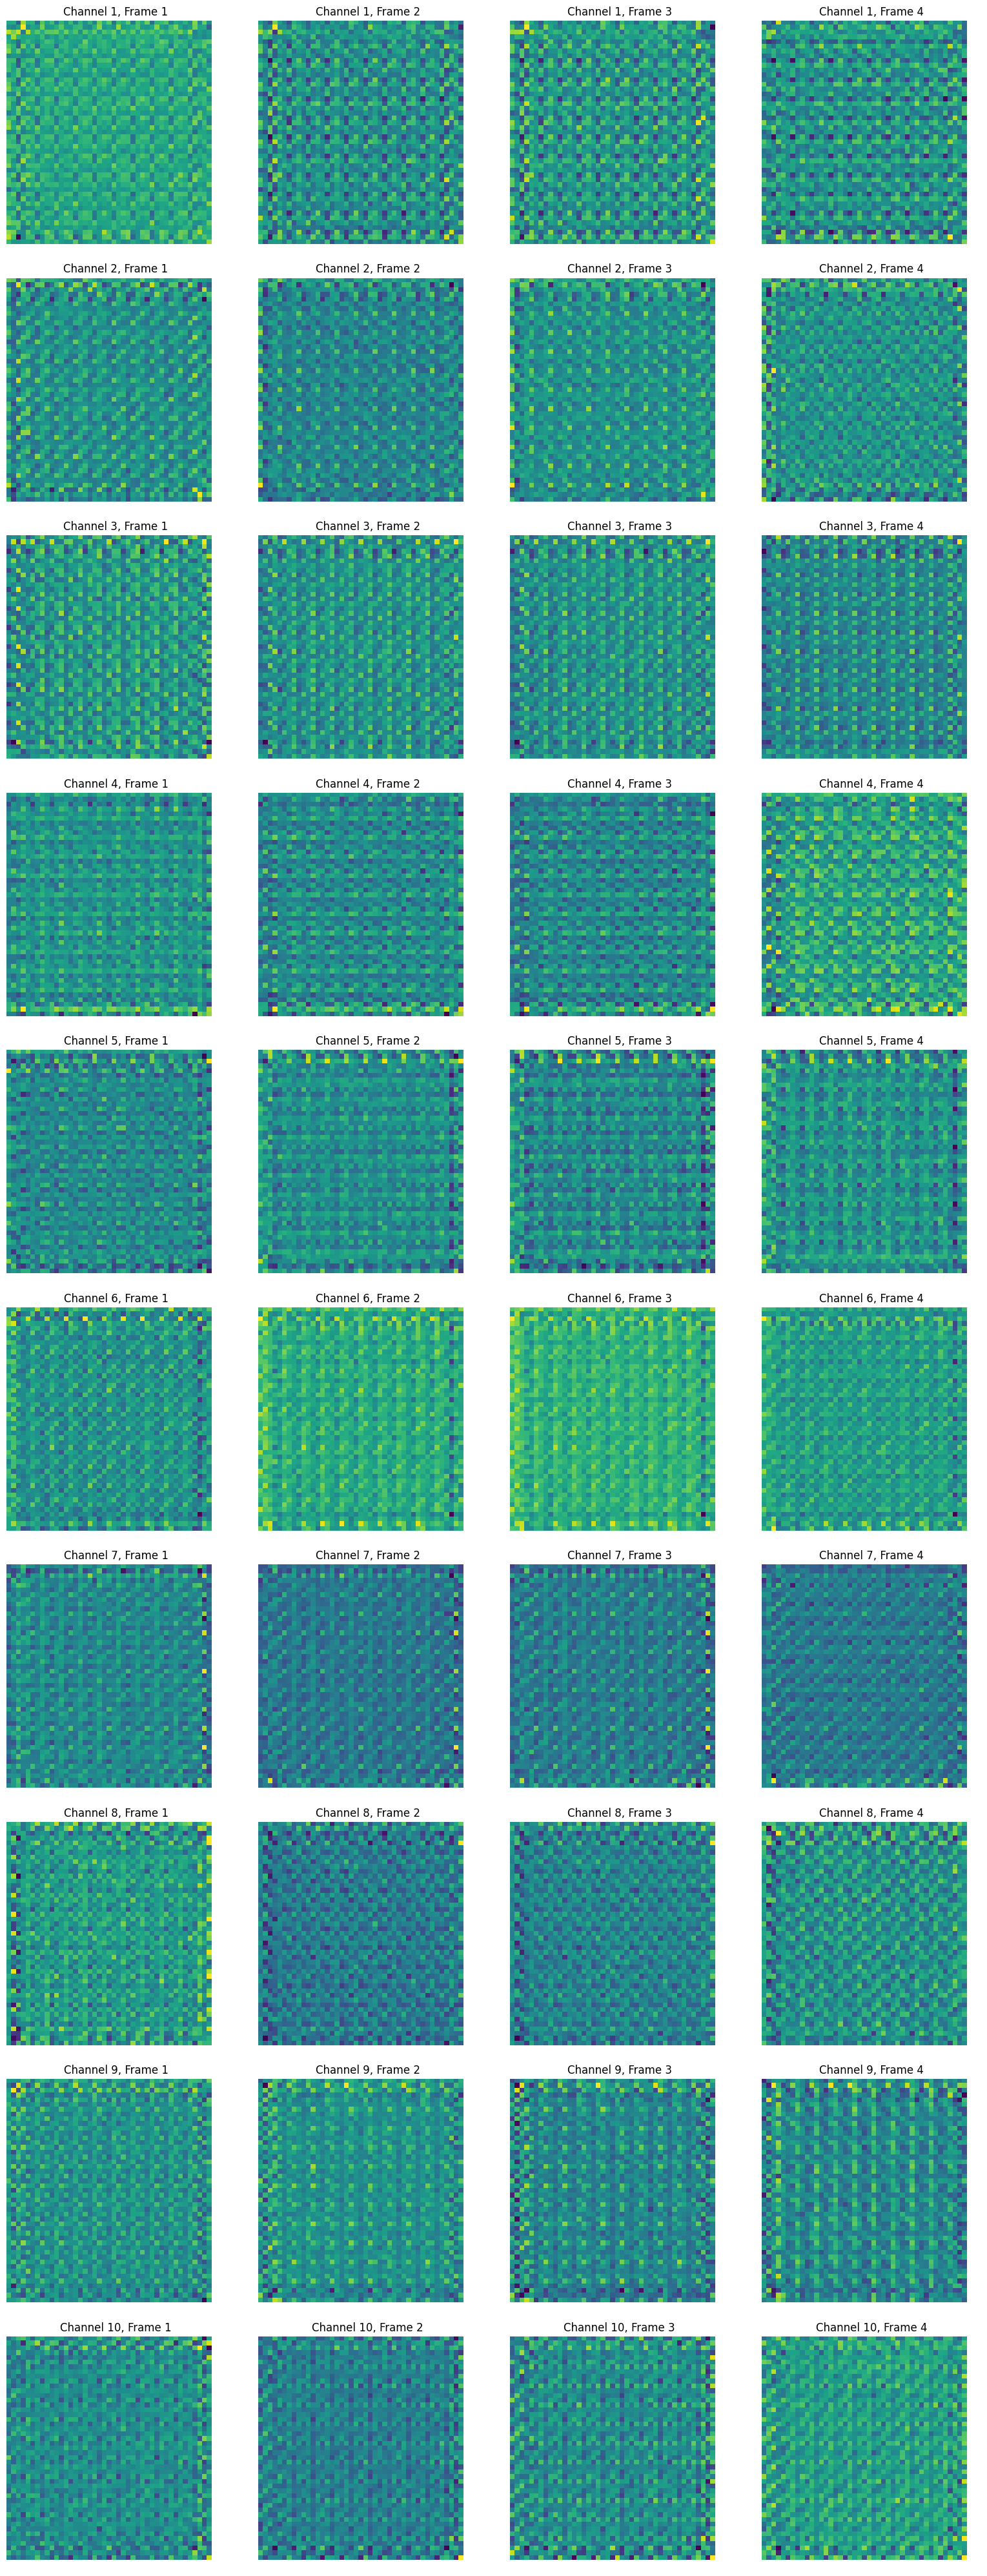

In [3]:
import matplotlib.pyplot as plt

def visualize_output(output_image):
    # output_image 形状：[batch_size, time_frames, channels, height, width]
    output_image = output_image.squeeze(0).detach()  # 移除 batch 维度，并断开与计算图的连接
    output_image = output_image.cpu().numpy()  # 将张量转换为 NumPy 数组
    
    time_frames = output_image.shape[0]  # 时间帧数
    channels = output_image.shape[1]     # 通道数
    height = output_image.shape[2]
    width = output_image.shape[3]
    
    fig, axes = plt.subplots(channels, 4, figsize=(16, channels * 4))

    for channel in range(channels):
        for frame in range(4):  # 只显示前4帧影像
            ax = axes[channel, frame] if channels > 1 else axes[frame]
            ax.imshow(output_image[frame, channel, :, :], cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Channel {channel+1}, Frame {frame+1}')

    plt.tight_layout()
    plt.show()

# 假设 `output_image` 是模型输出
# output_image = model(data_sample)

# 可视化结果
visualize_output(output_image)
